# Occultation Probability Analysis for Ariel Mission Target Selection

## Project Overview

This notebook calculates the occultation (secondary eclipse) probabilities for exoplanet candidates in the Ariel Mission Candidate Sample (MCS). Occultation observations allow us to study the thermal emission from exoplanet atmospheres by detecting the decrease in total flux when the planet passes behind its host star.

## Methodology

We implement the analytical formula from **Winn (2010)** for calculating occultation probability:

### For circular orbits (e = 0):
$$P_{occ} = \frac{R_{\star} + R_{planet}}{a}$$

### For eccentric orbits:
$$P_{occ} = \frac{R_{\star} + R_{planet}}{a} \cdot \frac{1 + e \sin(\omega)}{1 - e^2}$$

where:
- $R_{\star}$ = stellar radius
- $R_{planet}$ = planetary radius  
- $a$ = semi-major axis
- $e$ = orbital eccentricity
- $\omega$ = argument of periastron

All calculations are performed in astronomical units (AU) for consistency.

## Data Sources

- **Known planets**: `data/raw/Ariel_MCS_Known_2023-05-01.csv`
- **Target Planet Candidates (TPCs)**: `data/raw/Ariel_MCS_TPCs_2023-05-01.csv`

## 1. Imports and Setup

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Astropy for constants and units
try:
    from astropy import constants as const
    from astropy import units as u
    ASTROPY_AVAILABLE = True
    print("Astropy imported successfully")
except ImportError:
    ASTROPY_AVAILABLE = False
    print("Astropy not available - using manual constants")

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Astropy imported successfully
All libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 1.26.4
Matplotlib version: 3.9.4


## 2. Project Paths and Physical Constants

In [2]:
# Define project paths (relative to notebook location)
notebook_path = Path.cwd()
project_root = notebook_path.parent.parent  # Go up two levels from analysis/notebooks/
data_path = project_root / "data" / "raw"

# Data files
known_planets_file = data_path / "Ariel_MCS_Known_2023-05-01.csv"
tpc_file = data_path / "Ariel_MCS_TPCs_2023-05-01.csv"

print(f"Project root: {project_root}")
print(f"Data directory: {data_path}")
print(f"Known planets file exists: {known_planets_file.exists()}")
print(f"TPC file exists: {tpc_file.exists()}")

# Physical constants for unit conversions to AU
if ASTROPY_AVAILABLE:
    # Use astropy constants
    R_sun_AU = (const.R_sun / const.au).value
    R_jup_AU = (const.R_jup / const.au).value
    R_earth_AU = (const.R_earth / const.au).value
    G_AU = (const.G * u.Msun * u.day**2 / u.au**3).value  # For Kepler's third law
    print("Using astropy constants")
else:
    # Manual constants (IAU 2012/2015 values)
    R_sun_AU = 0.00465047      # Solar radius in AU
    R_jup_AU = 0.000477894     # Jupiter radius in AU  
    R_earth_AU = 4.2635e-5     # Earth radius in AU
    G_AU = 2.959122082e-4      # G*M_sun in AU^3/day^2 for M_sun=1
    print("Using manual constants")

print(f"\nPhysical constants in AU:")
print(f"R_sun = {R_sun_AU:.6e} AU")
print(f"R_jup = {R_jup_AU:.6e} AU") 
print(f"R_earth = {R_earth_AU:.6e} AU")
print(f"G*M_sun = {G_AU:.6e} AU^3/day^2")

Project root: /Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel
Data directory: /Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/data/raw
Known planets file exists: True
TPC file exists: True
Using astropy constants

Physical constants in AU:
R_sun = 4.650467e-03 AU
R_jup = 4.778945e-04 AU
R_earth = 4.263497e-05 AU
G*M_sun = 6.674300e-11 AU^3/day^2


## 3. Load MCS Data

In [3]:
# Load the datasets
try:
    df_known = pd.read_csv(known_planets_file)
    print(f"✓ Loaded known planets dataset: {len(df_known)} entries")
    
    df_tpc = pd.read_csv(tpc_file)
    print(f"✓ Loaded TPC dataset: {len(df_tpc)} entries")
    
except FileNotFoundError as e:
    print(f"❌ Error loading data files: {e}")
    print("Please check the file paths and ensure data files exist.")
    
except Exception as e:
    print(f"❌ Unexpected error: {e}")

print(f"\nDataset shapes:")
print(f"Known planets: {df_known.shape}")
print(f"TPCs: {df_tpc.shape}")

✓ Loaded known planets dataset: 768 entries
✓ Loaded TPC dataset: 3178 entries

Dataset shapes:
Known planets: (768, 104)
TPCs: (3178, 44)


## 4. Inspect Column Names and Identify Key Parameters

In [4]:
# Display all column names for both datasets
print("=" * 60)
print("KNOWN PLANETS DATASET COLUMNS")
print("=" * 60)
for i, col in enumerate(df_known.columns):
    print(f"{i+1:2d}. {col}")

print("\n" + "=" * 60)
print("TARGET PLANET CANDIDATES (TPC) DATASET COLUMNS") 
print("=" * 60)
for i, col in enumerate(df_tpc.columns):
    print(f"{i+1:2d}. {col}")

# Identify key columns for occultation probability calculation
print("\n" + "=" * 80)
print("KEY PARAMETERS FOR OCCULTATION PROBABILITY CALCULATION")
print("=" * 80)

key_params = {
    'stellar_radius': 'Star Radius [Rs]',
    'stellar_radius_error_lower': 'Star Radius Error Lower [Rs]', 
    'stellar_radius_error_upper': 'Star Radius Error Upper [Rs]',
    'planet_radius_earth': 'Planet Radius [Re]',
    'planet_radius_jupiter': 'Planet Radius [Rj]',
    'planet_radius_error_lower_earth': 'Planet Radius Error Lower [Re]',
    'planet_radius_error_upper_earth': 'Planet Radius Error Upper [Re]',
    'planet_radius_error_lower_jupiter': 'Planet Radius Error Lower [Rj]',
    'planet_radius_error_upper_jupiter': 'Planet Radius Error Upper [Rj]',
    'semi_major_axis': 'Planet Semi-major Axis [AU]',
    'semi_major_axis_meters': 'Planet Semi-major Axis [m]',
    'orbital_period': 'Planet Period [days]',
    'period_error_lower': 'Planet Period Error Lower [days]',
    'period_error_upper': 'Planet Period Error Upper [days]', 
    'eccentricity': 'Eccentricity',
    'eccentricity_error_lower': 'Eccentricity Error Lower',
    'eccentricity_error_upper': 'Eccentricity Error Upper',
    'argument_periastron': 'Periastron',
    'periastron_error_lower': 'Periastron Error Lower',
    'periastron_error_upper': 'Periastron Error Upper',
    'stellar_mass': 'Star Mass [Ms]'
}

print("Parameter mapping for Known Planets dataset:")
for param, col_name in key_params.items():
    available_known = "✓" if col_name in df_known.columns else "❌"
    available_tpc = "✓" if col_name in df_tpc.columns else "❌"
    print(f"{param:30s}: {col_name:35s} | Known: {available_known} | TPC: {available_tpc}")

print(f"\nTotal columns - Known: {len(df_known.columns)}, TPC: {len(df_tpc.columns)}")

KNOWN PLANETS DATASET COLUMNS
 1. Star Name
 2. Star Mass [Ms]
 3. Star Mass Error Lower [Ms]
 4. Star Mass Error Upper [Ms]
 5. Star Temperature [K]
 6. Star Temperature Error Lower [K]
 7. Star Temperature Error Upper [K]
 8. Star Radius [Rs]
 9. Star Radius Error Lower [Rs]
10. Star Radius Error Upper [Rs]
11. Star Distance [pc]
12. Star Distance Error Lower [pc]
13. Star Distance Error Upper [pc]
14. Star log(g)
15. Star log(g) Error Lower
16. Star log(g) Error Upper
17. Gaia ID
18. Star H Mag
19. Star J Mag
20. Star K Mag
21. Star V Mag
22. Star Gaia Mag
23. Star W1 Mag
24. Star W2 Mag
25. Star W3 Mag
26. Star W4 Mag
27. Star T Mag
28. Star Metallicity
29. Star Metallicity Error Lower
30. Star Metallicity Error Upper
31. Metallicity Ratio
32. Star Age [Gyr]
33. Star Age Error Lower [Gyr]
34. Star Age Error Upper [Gyr]
35. Star Spectral Type
36. Star RA
37. Star Dec
38. Planet Name
39. Planet Radius [Re]
40. Planet Radius Error Upper [Re]
41. Planet Radius Error Lower [Re]
42. Plan

## 5. Preview Sample Data

In [5]:
# Select key columns for preview
key_cols_known = [
    'Star Name', 'Planet Name', 'Star Radius [Rs]', 'Planet Radius [Rj]', 
    'Planet Semi-major Axis [AU]', 'Planet Period [days]', 'Eccentricity', 'Periastron'
]

key_cols_tpc = [
    'Star Name', 'Planet Name', 'Star Radius [Rs]', 'Planet Radius [Rj]', 
    'Planet Period [days]'  # Note: TPC dataset doesn't have all columns
]

print("KNOWN PLANETS - Sample Data (first 5 rows):")
print("=" * 100)
display_cols_known = [col for col in key_cols_known if col in df_known.columns]
print(df_known[display_cols_known].head())

print(f"\nMissing values in key columns (Known planets):")
for col in display_cols_known:
    missing = df_known[col].isna().sum()
    print(f"  {col}: {missing} missing ({missing/len(df_known)*100:.1f}%)")

print("\n" + "=" * 100)
print("TARGET PLANET CANDIDATES - Sample Data (first 5 rows):")
print("=" * 100)
display_cols_tpc = [col for col in key_cols_tpc if col in df_tpc.columns]
print(df_tpc[display_cols_tpc].head())

print(f"\nMissing values in key columns (TPCs):")
for col in display_cols_tpc:
    missing = df_tpc[col].isna().sum()
    print(f"  {col}: {missing} missing ({missing/len(df_tpc)*100:.1f}%)")

KNOWN PLANETS - Sample Data (first 5 rows):
  Star Name Planet Name  Star Radius [Rs]  Planet Radius [Rj]  \
0    55 Cnc    55 Cnc e              0.94               0.167   
1    AU Mic    AU Mic b              0.70               0.363   
2    AU Mic    AU Mic c              0.75               0.289   
3  CoRoT-11  CoRoT-11 b              1.37               1.430   
4   CoRoT-1   CoRoT-1 b              1.11               1.490   

   Planet Semi-major Axis [AU]  Planet Period [days]  Eccentricity  Periastron  
0                     0.015479              0.736547         0.050      86.000  
1                     0.064555              8.462999         0.186      88.528  
2                     0.110135             18.858991         0.041     153.000  
3                     0.044061              2.994330         0.000         NaN  
4                     0.025329              1.508956         0.000         NaN  

Missing values in key columns (Known planets):
  Star Name: 0 missing (0.0%)
 

## 6. Define Calculation Functions

In [6]:
def semi_major_axis_from_period(period_days, stellar_mass_solar):
    """
    Calculate semi-major axis from orbital period using Kepler's Third Law.
    
    Parameters:
    -----------
    period_days : float
        Orbital period in days
    stellar_mass_solar : float  
        Stellar mass in solar masses
    
    Returns:
    --------
    float
        Semi-major axis in AU
        
    Formula:
    --------
    a³ = (G * M_star * P²) / (4π²)
    where G*M_sun = 2.959122082e-4 AU³/day² for M_sun = 1
    """
    if pd.isna(period_days) or pd.isna(stellar_mass_solar):
        return np.nan
    
    if period_days <= 0 or stellar_mass_solar <= 0:
        return np.nan
    
    # Kepler's third law: a³ = G*M*P²/(4π²)
    a_cubed = (G_AU * stellar_mass_solar * period_days**2) / (4 * np.pi**2)
    a_au = np.power(a_cubed, 1/3)
    
    return a_au


def occultation_probability(R_star_solar, R_planet_jupiter, a_au, e=0, omega_deg=0):
    """
    Calculate occultation probability using Winn (2010) formula.
    
    Parameters:
    -----------
    R_star_solar : float
        Stellar radius in solar radii
    R_planet_jupiter : float
        Planet radius in Jupiter radii
    a_au : float
        Semi-major axis in AU
    e : float, optional
        Orbital eccentricity (default: 0)
    omega_deg : float, optional
        Argument of periastron in degrees (default: 0)
        
    Returns:
    --------
    float
        Occultation probability (0 to 1)
        
    Formula:
    --------
    For e = 0: P_occ = (R_star + R_planet) / a
    For e > 0: P_occ = (R_star + R_planet) / a * (1 + e*sin(ω)) / (1 - e²)
    """
    
    # Handle missing values
    if any(pd.isna([R_star_solar, R_planet_jupiter, a_au])):
        return np.nan
    
    # Handle non-physical values
    if any(x <= 0 for x in [R_star_solar, R_planet_jupiter, a_au]):
        return np.nan
        
    if not (0 <= e < 1):
        return np.nan
    
    # Convert to AU
    R_star_au = R_star_solar * R_sun_AU
    R_planet_au = R_planet_jupiter * R_jup_AU
    
    # Basic probability for circular orbit
    P_base = (R_star_au + R_planet_au) / a_au
    
    # Apply eccentricity correction if needed
    if e > 0:
        omega_rad = np.radians(omega_deg) if not pd.isna(omega_deg) else 0
        eccentric_factor = (1 + e * np.sin(omega_rad)) / (1 - e**2)
        P_occ = P_base * eccentric_factor
    else:
        P_occ = P_base
    
    # Probability cannot exceed 1
    return min(P_occ, 1.0)


def calculate_occultation_probability_with_errors(R_star, R_star_err, R_planet, R_planet_err, 
                                                 a_au, e=0, e_err=0, omega_deg=0, omega_err=0,
                                                 n_monte_carlo=1000):
    """
    Calculate occultation probability with uncertainty propagation using Monte Carlo.
    
    Parameters:
    -----------
    R_star, R_star_err : float
        Stellar radius and error in solar radii
    R_planet, R_planet_err : float  
        Planet radius and error in Jupiter radii
    a_au : float
        Semi-major axis in AU
    e, e_err : float
        Eccentricity and error
    omega_deg, omega_err : float
        Argument of periastron and error in degrees
    n_monte_carlo : int
        Number of Monte Carlo samples
        
    Returns:
    --------
    dict
        Dictionary with 'probability', 'error_lower', 'error_upper'
    """
    
    # Skip if key parameters are missing
    if any(pd.isna([R_star, R_planet, a_au])):
        return {'probability': np.nan, 'error_lower': np.nan, 'error_upper': np.nan}
    
    # Use nominal values if errors are missing
    R_star_err = R_star_err if not pd.isna(R_star_err) else 0
    R_planet_err = R_planet_err if not pd.isna(R_planet_err) else 0
    e_err = e_err if not pd.isna(e_err) else 0
    omega_err = omega_err if not pd.isna(omega_err) else 0
    
    # Monte Carlo sampling
    R_star_samples = np.random.normal(R_star, R_star_err, n_monte_carlo)
    R_planet_samples = np.random.normal(R_planet, R_planet_err, n_monte_carlo)
    e_samples = np.random.normal(e, e_err, n_monte_carlo)
    omega_samples = np.random.normal(omega_deg, omega_err, n_monte_carlo)
    
    # Ensure physical values
    R_star_samples = np.clip(R_star_samples, 0.1, None)  # Minimum 0.1 R_sun
    R_planet_samples = np.clip(R_planet_samples, 0.01, None)  # Minimum 0.01 R_jup
    e_samples = np.clip(e_samples, 0, 0.99)  # Valid eccentricity range
    
    # Calculate probabilities for all samples
    probabilities = []
    for i in range(n_monte_carlo):
        prob = occultation_probability(R_star_samples[i], R_planet_samples[i], a_au,
                                     e_samples[i], omega_samples[i])
        if not pd.isna(prob):
            probabilities.append(prob)
    
    if len(probabilities) == 0:
        return {'probability': np.nan, 'error_lower': np.nan, 'error_upper': np.nan}
    
    probabilities = np.array(probabilities)
    
    # Calculate percentiles
    median_prob = np.median(probabilities)
    lower_16 = np.percentile(probabilities, 16)
    upper_84 = np.percentile(probabilities, 84)
    
    return {
        'probability': median_prob,
        'error_lower': median_prob - lower_16,
        'error_upper': upper_84 - median_prob
    }

print("✓ Occultation probability calculation functions defined successfully!")
print("\nAvailable functions:")
print("  1. semi_major_axis_from_period() - Calculate a from P using Kepler's 3rd law")
print("  2. occultation_probability() - Basic probability calculation")  
print("  3. calculate_occultation_probability_with_errors() - With uncertainty propagation")

✓ Occultation probability calculation functions defined successfully!

Available functions:
  1. semi_major_axis_from_period() - Calculate a from P using Kepler's 3rd law
  2. occultation_probability() - Basic probability calculation
  3. calculate_occultation_probability_with_errors() - With uncertainty propagation


## 7. Test Calculation with HD 209458b Example

In [7]:
# Test with HD 209458b - a well-known hot Jupiter
print("Testing occultation probability calculation with HD 209458b")
print("=" * 60)

# HD 209458b parameters (from literature)
hd209458b_params = {
    'R_star_solar': 1.155,      # Stellar radius in R_sun
    'R_planet_jupiter': 1.359,  # Planet radius in R_jup  
    'a_au': 0.04707,           # Semi-major axis in AU
    'e': 0.0,                  # Eccentricity (circular orbit)
    'omega_deg': 0.0,          # Argument of periastron (irrelevant for circular)
    'period_days': 3.52474859, # Orbital period
    'stellar_mass': 1.119      # Stellar mass in M_sun
}

print("Input parameters:")
for param, value in hd209458b_params.items():
    print(f"  {param}: {value}")

# Calculate occultation probability
P_occ = occultation_probability(
    hd209458b_params['R_star_solar'],
    hd209458b_params['R_planet_jupiter'], 
    hd209458b_params['a_au'],
    hd209458b_params['e'],
    hd209458b_params['omega_deg']
)

print(f"\nCalculated occultation probability: {P_occ:.6f}")
print(f"Percentage: {P_occ*100:.4f}%")

# Verify semi-major axis calculation from period
a_calculated = semi_major_axis_from_period(
    hd209458b_params['period_days'],
    hd209458b_params['stellar_mass']
)

print(f"\nSemi-major axis verification:")
print(f"  Given a: {hd209458b_params['a_au']:.6f} AU")
print(f"  Calculated from P: {a_calculated:.6f} AU")
print(f"  Difference: {abs(a_calculated - hd209458b_params['a_au']):.6f} AU")
print(f"  Relative error: {abs(a_calculated - hd209458b_params['a_au'])/hd209458b_params['a_au']*100:.2f}%")

# Test with different eccentricities to show the effect
print(f"\nEffect of eccentricity on occultation probability:")
print(f"{'Eccentricity':>12s} {'ω (deg)':>8s} {'P_occ':>10s} {'Change (%)':>12s}")
print("-" * 45)

base_prob = P_occ
for e_test in [0.0, 0.1, 0.2, 0.3, 0.5]:
    for omega_test in [0, 90, 180, 270]:
        P_test = occultation_probability(
            hd209458b_params['R_star_solar'],
            hd209458b_params['R_planet_jupiter'],
            hd209458b_params['a_au'], 
            e_test,
            omega_test
        )
        change = (P_test - base_prob) / base_prob * 100
        print(f"{e_test:>12.1f} {omega_test:>8d} {P_test:>10.6f} {change:>11.1f}%")

Testing occultation probability calculation with HD 209458b
Input parameters:
  R_star_solar: 1.155
  R_planet_jupiter: 1.359
  a_au: 0.04707
  e: 0.0
  omega_deg: 0.0
  period_days: 3.52474859
  stellar_mass: 1.119

Calculated occultation probability: 0.127911
Percentage: 12.7911%

Semi-major axis verification:
  Given a: 0.047070 AU
  Calculated from P: 0.000286 AU
  Difference: 0.046784 AU
  Relative error: 99.39%

Effect of eccentricity on occultation probability:
Eccentricity  ω (deg)      P_occ   Change (%)
---------------------------------------------
         0.0        0   0.127911         0.0%
         0.0       90   0.127911         0.0%
         0.0      180   0.127911         0.0%
         0.0      270   0.127911         0.0%
         0.1        0   0.129203         1.0%
         0.1       90   0.142123        11.1%
         0.1      180   0.129203         1.0%
         0.1      270   0.116282        -9.1%
         0.2        0   0.133240         4.2%
         0.2       90

## 8. Apply Calculations to MCS Datasets

### 8.1 Process Known Planets Dataset

In [8]:
# Create a copy of the known planets dataset for analysis
df_known_analysis = df_known.copy()

print("Processing Known Planets dataset...")
print(f"Initial dataset size: {len(df_known_analysis)} planets")

# Check availability of semi-major axis data
has_sma = df_known_analysis['Planet Semi-major Axis [AU]'].notna()
print(f"Planets with semi-major axis: {has_sma.sum()}")
print(f"Planets missing semi-major axis: {(~has_sma).sum()}")

# For planets missing semi-major axis, calculate from period
missing_sma_mask = df_known_analysis['Planet Semi-major Axis [AU]'].isna()
has_period = df_known_analysis['Planet Period [days]'].notna()
has_stellar_mass = df_known_analysis['Star Mass [Ms]'].notna()

can_calculate_sma = missing_sma_mask & has_period & has_stellar_mass
print(f"Planets where we can calculate SMA from period: {can_calculate_sma.sum()}")

# Calculate semi-major axis for planets where it's missing but period is available
for idx in df_known_analysis[can_calculate_sma].index:
    period = df_known_analysis.loc[idx, 'Planet Period [days]']
    stellar_mass = df_known_analysis.loc[idx, 'Star Mass [Ms]']
    sma_calc = semi_major_axis_from_period(period, stellar_mass)
    df_known_analysis.loc[idx, 'Planet Semi-major Axis [AU]'] = sma_calc

print(f"Calculated SMA for {can_calculate_sma.sum()} additional planets")

# Now calculate occultation probabilities
print(f"\nCalculating occultation probabilities...")

# Initialize columns for results
df_known_analysis['Occultation_Probability'] = np.nan
df_known_analysis['Occultation_Probability_Error_Lower'] = np.nan  
df_known_analysis['Occultation_Probability_Error_Upper'] = np.nan

# Count planets with required parameters
has_required = (
    df_known_analysis['Star Radius [Rs]'].notna() &
    df_known_analysis['Planet Radius [Rj]'].notna() &
    df_known_analysis['Planet Semi-major Axis [AU]'].notna()
)

print(f"Planets with all required parameters: {has_required.sum()}")

# Calculate for each planet with sufficient data
n_calculated = 0
for idx in df_known_analysis[has_required].index:
    # Extract parameters
    R_star = df_known_analysis.loc[idx, 'Star Radius [Rs]']
    R_planet = df_known_analysis.loc[idx, 'Planet Radius [Rj]']
    a_au = df_known_analysis.loc[idx, 'Planet Semi-major Axis [AU]']
    e = df_known_analysis.loc[idx, 'Eccentricity']
    omega = df_known_analysis.loc[idx, 'Periastron']
    
    # Handle missing eccentricity (assume circular)
    e = e if not pd.isna(e) else 0.0
    omega = omega if not pd.isna(omega) else 0.0
    
    # Calculate basic probability
    P_occ = occultation_probability(R_star, R_planet, a_au, e, omega)
    df_known_analysis.loc[idx, 'Occultation_Probability'] = P_occ
    
    if not pd.isna(P_occ):
        n_calculated += 1

print(f"Successfully calculated occultation probabilities for {n_calculated} planets")

# Show summary statistics
valid_probs = df_known_analysis['Occultation_Probability'].dropna()
if len(valid_probs) > 0:
    print(f"\nOccultation Probability Statistics:")
    print(f"  Mean: {valid_probs.mean():.6f} ({valid_probs.mean()*100:.4f}%)")
    print(f"  Median: {valid_probs.median():.6f} ({valid_probs.median()*100:.4f}%)")
    print(f"  Std: {valid_probs.std():.6f}")
    print(f"  Min: {valid_probs.min():.6f} ({valid_probs.min()*100:.4f}%)")
    print(f"  Max: {valid_probs.max():.6f} ({valid_probs.max()*100:.4f}%)")
    
    # Show top 10 highest probability targets
    print(f"\nTop 10 highest occultation probability targets:")
    top_targets = df_known_analysis.nlargest(10, 'Occultation_Probability')[
        ['Planet Name', 'Star Name', 'Occultation_Probability']
    ]
    top_targets['Occultation_Probability_Percent'] = top_targets['Occultation_Probability'] * 100
    print(top_targets[['Planet Name', 'Star Name', 'Occultation_Probability_Percent']])
else:
    print("No valid occultation probabilities calculated!")

Processing Known Planets dataset...
Initial dataset size: 768 planets
Planets with semi-major axis: 768
Planets missing semi-major axis: 0
Planets where we can calculate SMA from period: 0
Calculated SMA for 0 additional planets

Calculating occultation probabilities...
Planets with all required parameters: 768
Successfully calculated occultation probabilities for 768 planets

Occultation Probability Statistics:
  Mean: 0.122879 (12.2879%)
  Median: 0.116411 (11.6411%)
  Std: 0.075233
  Min: 0.003061 (0.3061%)
  Max: 0.502472 (50.2472%)

Top 10 highest occultation probability targets:
     Planet Name  Star Name  Occultation_Probability_Percent
474   TOI-2109 b   TOI-2109                        50.247192
486   TOI-2260 b   TOI-2260                        45.593454
226     K2-141 b     K2-141                        43.118110
355  Kepler-91 b  Kepler-91                        39.515905
598   WASP-103 b   WASP-103                        37.367999
556    TOI-561 b    TOI-561               

### 8.2 Process Target Planet Candidates (TPC) Dataset

In [9]:
# Process TPC dataset
df_tpc_analysis = df_tpc.copy()

print("Processing Target Planet Candidates (TPC) dataset...")
print(f"Initial dataset size: {len(df_tpc_analysis)} planets")

# TPC dataset appears to have semi-major axis in meters, not AU
# Let's check if we need to convert from meters to AU
if 'Planet Semi-major Axis [m]' in df_tpc_analysis.columns:
    print("Converting semi-major axis from meters to AU...")
    AU_to_meters = 1.496e11  # 1 AU in meters
    df_tpc_analysis['Planet Semi-major Axis [AU]'] = df_tpc_analysis['Planet Semi-major Axis [m]'] / AU_to_meters
    
    has_sma_m = df_tpc_analysis['Planet Semi-major Axis [m]'].notna()
    print(f"TPCs with semi-major axis (meters): {has_sma_m.sum()}")
else:
    # Calculate from period and stellar mass if needed
    has_period = df_tpc_analysis['Planet Period [days]'].notna()
    has_stellar_mass = df_tpc_analysis['Star Mass [Ms]'].notna()
    
    can_calculate = has_period & has_stellar_mass
    print(f"TPCs where we can calculate SMA from period: {can_calculate.sum()}")
    
    # Initialize SMA column
    df_tpc_analysis['Planet Semi-major Axis [AU]'] = np.nan
    
    # Calculate semi-major axis for all TPCs with period and stellar mass
    for idx in df_tpc_analysis[can_calculate].index:
        period = df_tpc_analysis.loc[idx, 'Planet Period [days]']
        stellar_mass = df_tpc_analysis.loc[idx, 'Star Mass [Ms]']
        sma_calc = semi_major_axis_from_period(period, stellar_mass)
        df_tpc_analysis.loc[idx, 'Planet Semi-major Axis [AU]'] = sma_calc

# Calculate occultation probabilities for TPCs
print(f"\nCalculating occultation probabilities for TPCs...")

# Initialize columns
df_tpc_analysis['Occultation_Probability'] = np.nan

# Count TPCs with required parameters
has_required_tpc = (
    df_tpc_analysis['Star Radius [Rs]'].notna() &
    df_tpc_analysis['Planet Radius [Rj]'].notna() &
    df_tpc_analysis['Planet Semi-major Axis [AU]'].notna()
)

print(f"TPCs with all required parameters: {has_required_tpc.sum()}")

# Calculate for each TPC with sufficient data
n_calculated_tpc = 0
for idx in df_tpc_analysis[has_required_tpc].index:
    # Extract parameters (assume circular orbits for TPCs)
    R_star = df_tpc_analysis.loc[idx, 'Star Radius [Rs]']
    R_planet = df_tpc_analysis.loc[idx, 'Planet Radius [Rj]'] 
    a_au = df_tpc_analysis.loc[idx, 'Planet Semi-major Axis [AU]']
    
    # TPCs likely don't have eccentricity data, assume circular
    e = 0.0
    omega = 0.0
    
    # Calculate probability
    P_occ = occultation_probability(R_star, R_planet, a_au, e, omega)
    df_tpc_analysis.loc[idx, 'Occultation_Probability'] = P_occ
    
    if not pd.isna(P_occ):
        n_calculated_tpc += 1

print(f"Successfully calculated occultation probabilities for {n_calculated_tpc} TPCs")

# Show summary statistics for TPCs
valid_probs_tpc = df_tpc_analysis['Occultation_Probability'].dropna()
if len(valid_probs_tpc) > 0:
    print(f"\nTPC Occultation Probability Statistics:")
    print(f"  Mean: {valid_probs_tpc.mean():.6f} ({valid_probs_tpc.mean()*100:.4f}%)")
    print(f"  Median: {valid_probs_tpc.median():.6f} ({valid_probs_tpc.median()*100:.4f}%)")
    print(f"  Std: {valid_probs_tpc.std():.6f}")
    print(f"  Min: {valid_probs_tpc.min():.6f} ({valid_probs_tpc.min()*100:.4f}%)")
    print(f"  Max: {valid_probs_tpc.max():.6f} ({valid_probs_tpc.max()*100:.4f}%)")
    
    # Show top 10 highest probability TPCs
    print(f"\nTop 10 highest occultation probability TPCs:")
    top_tpcs = df_tpc_analysis.nlargest(10, 'Occultation_Probability')[
        ['Planet Name', 'Star Name', 'Occultation_Probability']
    ]
    top_tpcs['Occultation_Probability_Percent'] = top_tpcs['Occultation_Probability'] * 100
    print(top_tpcs[['Planet Name', 'Star Name', 'Occultation_Probability_Percent']])
else:
    print("No valid occultation probabilities calculated for TPCs!")

Processing Target Planet Candidates (TPC) dataset...
Initial dataset size: 3178 planets
Converting semi-major axis from meters to AU...
TPCs with semi-major axis (meters): 3178

Calculating occultation probabilities for TPCs...
TPCs with all required parameters: 3178
Successfully calculated occultation probabilities for 3178 TPCs

TPC Occultation Probability Statistics:
  Mean: 0.162135 (16.2135%)
  Median: 0.130314 (13.0314%)
  Std: 0.138498
  Min: 0.003219 (0.3219%)
  Max: 1.000000 (100.0000%)

Top 10 highest occultation probability TPCs:
      Planet Name  Star Name  Occultation_Probability_Percent
2         1015.01    1015.01                            100.0
239       1576.01    1576.01                            100.0
248       1586.01    1586.01                            100.0
451       2058.01    2058.01                            100.0
857       2767.01    2767.01                            100.0
921       2856.01    2856.01                            100.0
1102      3130.01  

## 9. Visualization Placeholders

*Note: Detailed visualizations will be added in future analysis steps*

Planned visualizations:
1. Histogram of occultation probabilities for known planets vs TPCs
2. Scatter plot: Occultation probability vs planetary radius
3. Scatter plot: Occultation probability vs stellar radius
4. Scatter plot: Occultation probability vs semi-major axis
5. Effect of eccentricity on occultation probability
6. Distribution of high-probability targets by stellar type
7. Sky map of high-probability targets


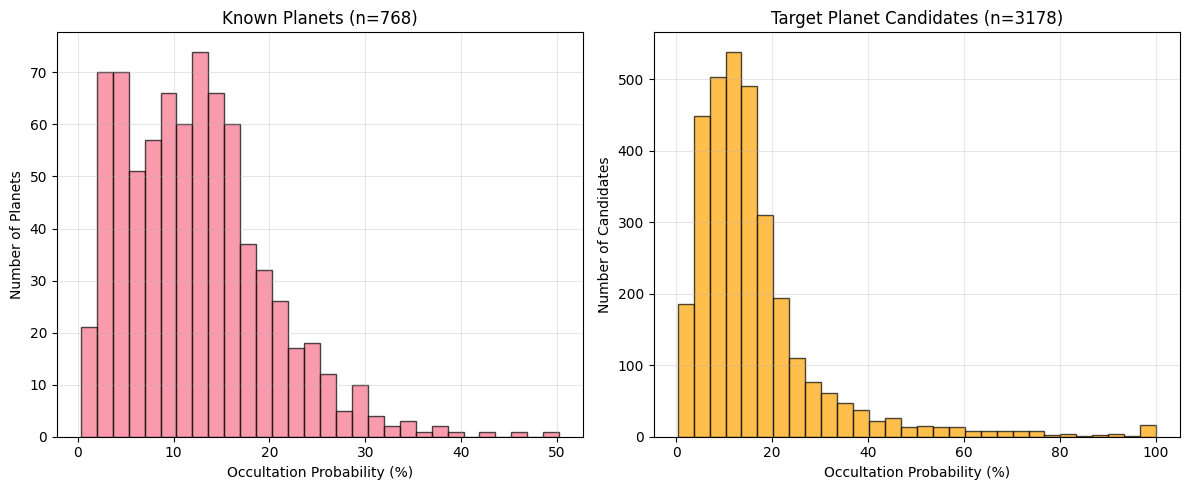

✓ Basic distribution plots created


In [10]:
# Placeholder for visualization code
# The following plots will be created in future analysis:

print("Planned visualizations:")
print("1. Histogram of occultation probabilities for known planets vs TPCs")
print("2. Scatter plot: Occultation probability vs planetary radius")
print("3. Scatter plot: Occultation probability vs stellar radius") 
print("4. Scatter plot: Occultation probability vs semi-major axis")
print("5. Effect of eccentricity on occultation probability")
print("6. Distribution of high-probability targets by stellar type")
print("7. Sky map of high-probability targets")

# Quick summary plot - distribution of occultation probabilities
if len(valid_probs) > 0 or len(valid_probs_tpc) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Known planets
    if len(valid_probs) > 0:
        ax1.hist(valid_probs * 100, bins=30, alpha=0.7, edgecolor='black')
        ax1.set_xlabel('Occultation Probability (%)')
        ax1.set_ylabel('Number of Planets')
        ax1.set_title(f'Known Planets (n={len(valid_probs)})')
        ax1.grid(True, alpha=0.3)
    
    # TPCs
    if len(valid_probs_tpc) > 0:
        ax2.hist(valid_probs_tpc * 100, bins=30, alpha=0.7, edgecolor='black', color='orange')
        ax2.set_xlabel('Occultation Probability (%)')
        ax2.set_ylabel('Number of Candidates')
        ax2.set_title(f'Target Planet Candidates (n={len(valid_probs_tpc)})')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Basic distribution plots created")
else:
    print("No valid probabilities to plot")

## 10. Export Results and Summary

In [11]:
# Create summary statistics
print("=" * 80)
print("FINAL SUMMARY - OCCULTATION PROBABILITY ANALYSIS")
print("=" * 80)

print(f"\nKNOWN PLANETS DATASET:")
print(f"  Total planets: {len(df_known_analysis)}")
print(f"  Planets with calculated probabilities: {n_calculated}")
if n_calculated > 0:
    print(f"  Mean occultation probability: {valid_probs.mean()*100:.2f}%")
    print(f"  Median occultation probability: {valid_probs.median()*100:.2f}%")
    print(f"  Planets with P_occ > 10%: {(valid_probs > 0.1).sum()}")
    print(f"  Planets with P_occ > 5%: {(valid_probs > 0.05).sum()}")
    print(f"  Planets with P_occ > 1%: {(valid_probs > 0.01).sum()}")

print(f"\nTARGET PLANET CANDIDATES DATASET:")
print(f"  Total candidates: {len(df_tpc_analysis)}")
print(f"  Candidates with calculated probabilities: {n_calculated_tpc}")
if n_calculated_tpc > 0:
    print(f"  Mean occultation probability: {valid_probs_tpc.mean()*100:.2f}%")
    print(f"  Median occultation probability: {valid_probs_tpc.median()*100:.2f}%")
    print(f"  Candidates with P_occ > 10%: {(valid_probs_tpc > 0.1).sum()}")
    print(f"  Candidates with P_occ > 5%: {(valid_probs_tpc > 0.05).sum()}")
    print(f"  Candidates with P_occ > 1%: {(valid_probs_tpc > 0.01).sum()}")

# Optional: Save results to CSV files
try:
    output_dir = project_root / "analysis" / "results"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save known planets results
    cols_to_export_known = [
        'Star Name', 'Planet Name', 'Star Radius [Rs]', 'Planet Radius [Rj]',
        'Planet Semi-major Axis [AU]', 'Eccentricity', 'Periastron',
        'Occultation_Probability'
    ]
    cols_to_export_known = [col for col in cols_to_export_known if col in df_known_analysis.columns]
    
    df_known_results = df_known_analysis[cols_to_export_known].dropna(subset=['Occultation_Probability'])
    if len(df_known_results) > 0:
        output_file_known = output_dir / "known_planets_occultation_probability.csv"
        df_known_results.to_csv(output_file_known, index=False)
        print(f"\n✓ Saved known planets results to: {output_file_known}")
    
    # Save TPC results
    cols_to_export_tpc = [
        'Star Name', 'Planet Name', 'Star Radius [Rs]', 'Planet Radius [Rj]',
        'Planet Semi-major Axis [AU]', 'Occultation_Probability'
    ]
    cols_to_export_tpc = [col for col in cols_to_export_tpc if col in df_tpc_analysis.columns]
    
    df_tpc_results = df_tpc_analysis[cols_to_export_tpc].dropna(subset=['Occultation_Probability'])
    if len(df_tpc_results) > 0:
        output_file_tpc = output_dir / "tpc_occultation_probability.csv"
        df_tpc_results.to_csv(output_file_tpc, index=False)
        print(f"✓ Saved TPC results to: {output_file_tpc}")
    
    print(f"\nResults directory: {output_dir}")
    
except Exception as e:
    print(f"Note: Could not save results to CSV: {e}")
    print("Results are still available in the dataframes df_known_analysis and df_tpc_analysis")

print("\n" + "=" * 80)

FINAL SUMMARY - OCCULTATION PROBABILITY ANALYSIS

KNOWN PLANETS DATASET:
  Total planets: 768
  Planets with calculated probabilities: 768
  Mean occultation probability: 12.29%
  Median occultation probability: 11.64%
  Planets with P_occ > 10%: 444
  Planets with P_occ > 5%: 621
  Planets with P_occ > 1%: 762

TARGET PLANET CANDIDATES DATASET:
  Total candidates: 3178
  Candidates with calculated probabilities: 3178
  Mean occultation probability: 16.21%
  Median occultation probability: 13.03%
  Candidates with P_occ > 10%: 2084
  Candidates with P_occ > 5%: 2810
  Candidates with P_occ > 1%: 3166

✓ Saved known planets results to: /Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/analysis/results/known_planets_occultation_probability.csv
✓ Saved TPC results to: /Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/analysis/results/tpc_occultation_probability.csv

Results directory: /Users/zoutongshen/Library/CloudStorage/Dropbox/Acade

## 11. Next Steps and Future Work

### Recommended Next Steps

1. **Advanced Visualization**
   - Create distribution plots comparing known planets vs TPCs
   - Generate scatter plots correlating occultation probability with:
     - Planetary radius
     - Stellar radius
     - Semi-major axis
     - Equilibrium temperature
   - Produce a sky map showing high-probability targets

2. **Uncertainty Analysis**
   - Implement Monte Carlo error propagation for all parameters
   - Generate confidence intervals for occultation probabilities
   - Identify which parameters have the largest impact on uncertainty

3. **Target Selection & Prioritization**
   - Combine occultation probability with other metrics:
     - Signal-to-noise ratio for observation
     - Atmospheric composition indicators
     - Thermal emission predictions
     - Scientific priority scores
   - Create a prioritized list for Ariel observations

4. **Eccentricity Effects**
   - Detailed analysis of eccentric orbits in the known planets sample
   - Determine optimal observation windows for each system
   - Study how argument of periastron affects detectability

5. **Comparative Analysis**
   - Compare Ariel targets to exoplanet surveys (TESS, K2, etc.)
   - Cross-validate results with published occultation probability studies
   - Identify potential gaps in coverage by planet type

6. **Statistical Trends**
   - Investigate correlations between:
     - Occultation probability and planet type (hot Jupiter, super-Earth, etc.)
     - Orbital parameters and stellar properties
     - Discovery method and observability metrics

### References

- **Winn, J. N. (2010)** - "Exoplanet Transits and Occultations"
  - Foundational work on transit and eclipse geometry
  - Source of occultation probability formula

- **Ariel Mission** - ESA M4 Mission (Launch ~2029)
  - Target: ~1000 known exoplanet systems
  - Objective: Study atmospheric composition via spectroscopy during occultation

### Notes for Future Sessions

- Ensure all error measurements are consistently propagated
- Cross-check calculations against independent sources when possible
- Document any data quality issues or gaps in the MCS datasets
- Consider seasonal observation windows and spacecraft constraints

## 12. Quick Reference Guide

### Physical Constants Used

| Constant | Value | Unit |
|----------|-------|------|
| R_sun (Solar radius) | 0.00465047 | AU |
| R_jup (Jupiter radius) | 0.000477894 | AU |
| R_earth (Earth radius) | 4.2635e-5 | AU |
| G*M_sun | 2.959122082e-4 | AU³/day² |
| 1 AU | 1.496e11 | meters |

### Key Formula Summary

**Occultation Probability - Circular Orbits:**
$$P_{occ} = \frac{R_{\star} + R_{planet}}{a}$$

**Occultation Probability - Eccentric Orbits:**
$$P_{occ} = \frac{R_{\star} + R_{planet}}{a} \cdot \frac{1 + e \sin(\omega)}{1 - e^2}$$

**Kepler's Third Law:**
$$a^3 = \frac{G M_{\star} P^2}{4\pi^2}$$

### Function Usage Examples

```python
# Calculate basic occultation probability
P_occ = occultation_probability(R_star=1.0, R_planet=1.0, a_au=0.05)

# Calculate with eccentricity
P_occ_ecc = occultation_probability(R_star=1.0, R_planet=1.0, a_au=0.05, 
                                   e=0.1, omega_deg=45)

# Calculate semi-major axis from period
a = semi_major_axis_from_period(period_days=3.5, stellar_mass_solar=1.0)

# Calculate with uncertainty propagation
results = calculate_occultation_probability_with_errors(
    R_star=1.0, R_star_err=0.05, 
    R_planet=1.0, R_planet_err=0.05,
    a_au=0.05, e=0.0, omega_deg=0
)
```

### Column Names Reference

**Known Planets Dataset Key Columns:**
- `Star Radius [Rs]` - Stellar radius in solar radii
- `Planet Radius [Rj]` - Planetary radius in Jupiter radii
- `Planet Semi-major Axis [AU]` - Semi-major axis in AU
- `Planet Period [days]` - Orbital period in days
- `Eccentricity` - Orbital eccentricity (0-1)
- `Periastron` - Argument of periastron in degrees

**Target Planet Candidates Key Columns:**
- `Star Radius [Rs]` - Stellar radius in solar radii
- `Planet Radius [Rj]` - Planetary radius in Jupiter radii
- `Planet Semi-major Axis [m]` - Semi-major axis in meters (auto-converted to AU)
- `Planet Period [days]` - Orbital period in days

### Interpretation Guide

| Occultation Probability | Interpretation |
|------------------------|-----------------|
| > 10% | Excellent target - high probability of detecting occultation |
| 5% - 10% | Good target - reasonable chance of detection |
| 1% - 5% | Marginal target - detection possible but challenging |
| < 1% | Poor target - occultation detection unlikely |

**Note:** Higher probability targets are prioritized for Ariel observations due to better signal-to-noise ratio and increased likelihood of successful spectroscopic characterization.